In [325]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image
import math
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from fuzzywuzzy import process
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
style.use('fivethirtyeight')


In [110]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'


In [111]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')
    

In [112]:
descriptions = df['job_description']
job_titles = df['job_title']


In [113]:
stop_words = set(stopwords.words('english'))
# additional stop words found in dataset
additional_stop_words = set(['Job','OpportunityAffirmative','Opportunity', 'monster','Most', 'Date', 'Apex', 'monster.com','Monstercom', 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID', 'Of', ])
stop_words = stop_words.union(additional_stop_words)

In [114]:
def get_column_word_counter(column):
    all_tokens = []
    location_tokens = []
    for elm in column:
        tokens = word_tokenize(elm)
        for token in tokens:
            stripped = re.sub(r'\W+', '', token)
            if stripped not in stop_words:
                if len(stripped) > 0:
                    loc = GeoText(stripped)
                    if(len(loc.cities) > 0):
                        location_tokens.append(stripped)
                    else:
                        all_tokens.append(stripped)  
    return Counter(all_tokens), Counter(location_tokens), all_tokens, location_tokens 


In [115]:
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

In [117]:
'''
function returns a counter object containing all locations mined from location column
'''
def get_location_counter(column):
    all_noun_tokens = []
    location_tokens = []
    
    for elm in column:
        # tokenize location as a sentence
        # needed because some elements contain alot of text
        sent = sent_tokenize(elm)
        for sent_tok in sent:
            # tokenize sentece
            words = word_tokenize(sent_tok)
            # tag words by part of speech
            tagged = nltk.pos_tag(words)
            nouns = []
            # collect all proper nouns
            for tup in tagged:
                if tup[1] == 'NNP':
                    nouns.append(tup[0])
            all_noun_tokens.append(nouns)
    
    for token in all_noun_tokens:
        tagged = nltk.pos_tag(token)
        # create named entity from all nouns
        namedEnt = nltk.ne_chunk(tagged, binary=True)
        for ent in namedEnt:
            if(hasattr(ent, 'label') and ent.label() == 'NE'):
                location_str = ' '.join(e[0] for e in ent)
                # find combined entities such as San Jose, Las Vegas, etc
                loc = GeoText(location_str)
                if(len(loc.cities) > 0):
                    location_tokens.append(location_str.title())
    return Counter(location_tokens)
         

In [118]:
locations = df['location']
loc_counter = get_location_counter(locations)


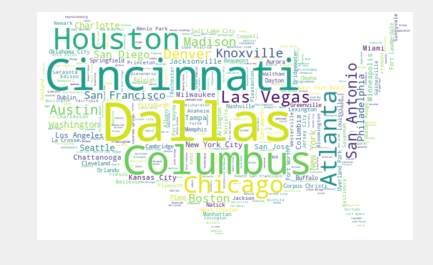

In [119]:
make_US_word_cloud(loc_counter, stop_words)


In [124]:
organization = df['organization']
sector = df['sector']
#organization[:100]


In [335]:
def find_industries(sector):
    all_tokens = []
    for sec in sector:
        words = word_tokenize(str(sec))
        for word in words:
            if word not in stop_words:
                all_tokens.append(word)
    return Counter(all_tokens)

def strip_word_remove_location(word):
    word = word.translate(translator)
    loc = GeoText(word)
    return word if len(loc.cities) == 0 and word != 'nan' else ''

def combine_industries(sector, organization, stop_words, industry_features):
    all_tokens = []
    industry_stop_words = set(['All','Not', 'Services','Other','Entry','Level', 'Development', 'R', 'D'])
    stop_words = stop_words.union(industry_stop_words)
    for i in range(len(df)):
        stripped_sec = strip_word_remove_location(str(sector[i]))
        stripped_org =  strip_word_remove_location(str(organization[i]))
        combined_str = stripped_sec + ' ' + stripped_org

        words = word_tokenize(combined_str)
        #print(words)
        temp_tokens = []
        words_length = len(words)
        for word in words:
            if(words_length < 20):
                if word not in stop_words:
                    all_tokens.append(word)
                    temp_tokens.append(word)
        for token in temp_tokens:
            fuzzy_match = process.extract(token, industry_features, limit=1)
            if(fuzzy_match[0][1] > 90):
                # generating labels with fuzzy matching
                # can improve
                print('Words: ', temp_tokens, end=' Label: ')
                print(fuzzy_match[0][0])
                break
        #print(temp_tokens)
            
        #tagged = nltk.pos_tag(temp_tokens)
        #namedEnt = nltk.ne_chunk(tagged, binary=True)
        #print(namedEnt)
    return Counter(all_tokens)

In [336]:
#industry_cnt = find_industries(sector)
industry_features = set(['Executive', 'Sofware', 'Retail', 'Healthcare', 'Finance', 'Transportation', 'Construction', 'Engineering', 'Manufacturing'])        

In [337]:
#industry_cnt.most_common(50)
industry = combine_industries(sector, organization, stop_words, industry_features)
#industry.most_common(100)
# need to test the use of naive bayes algo

Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Construction', 'Industrial', 'Facilities', 'InfrastructureConstruction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Civil', 'Structural', 'EngineeringGeneral', 'Engineering'] Label: Engineering
Words:  ['Accounting', 'Finance', 'Insurance', 'Accounting', 'Auditing'] Label: Finance
Words:  ['General', 'Engineering'] Label: Engineering
Words:  ['Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Engineering'] Label: Engineering
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Engineering'] Label: Engineering
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Engineering'] Label: Engineering
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager

Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Energy', 'Utilities', 'Manufacturing', 'Business'] Label: Manufacturing
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Food', 'Hospitality', 'Healthcare'] Label: Healthcare
Words:  ['Business', 'Strategic', 'Management', 'Healthcare'] Label: Healthcare
Words:  ['Customer', 'Support', 'Client', 'Care', 'Retail', 'Advertising', 'PR', 'Business'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Customer', 'Support', 'Client', 'Care', 'Retail', 'Telecommunications', 'Advertising', 'PR'] Label: Retail
Words:  ['Manufacturing'

Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Human', 'Resources', 'Manufacturing'] Label: Manufacturing
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance', 'Transport', 'Storage', 'Materials'] Label: Finance
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Engineering'] Label: Engineering
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Sales', 'Retail', 'Business', 'Advertising', 'PR', 'Staffing', 'Employment', 'Agencies', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Rental', 'ServicesBusiness', 'OtherOther', 'Classified'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Computer', 'Software'] Label: Sofware
Words:  ['Sale

Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Management', 'Consulting'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Hardware', 'Computer', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'HardwareComputer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'HardwareComputer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words: 

Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Quality', 'Assurance', 'Safety', 'Retail'] Label: Retail
Words:  ['Travel', 'Transportation', 'Tourism', 'Government', 'Military'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
W

Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Retail'] Label: Retail
Words:  ['IT', 'Software', 'Aerospace', 'Defense'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'Manufacturing', 'OtherPrinting', 'Publishing', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Manufacturing', 'OtherArchitectural', 'Design', 'ServicesConstruction', 'Residential', 'Commercial', 'Office'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Computer', 'Software'] Label: Retail
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Staffing', 'Employment', 

Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Staffing', 'Employment', 'Agencies'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Energy', 'Utilities', 'Engineering'] Label: Engineering
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:

Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'AllBusiness'] Label: Retail
Words:  ['Sales', 'Retail', 'Busin

Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Classified'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'ServicesStaffing', 'Employment', 'Agencies'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Hea

Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Man

Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Staffing', 'Employment', 'Agencies'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Computer', 'Network', 'SecurityGeneral', 'IT', 'Software'] Label: Sofware
Words:  ['

Words:  ['IT', 'Software'] Label: Sofware
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Bio

Words:  ['Computer', 'Network', 'SecurityGeneral', 'IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['General', 'IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc'] Label: Executive
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical

Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Engineering'] Label: Engineering
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'AllAutomotive', 'Sales', 'Repair', 'ServicesBusiness'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Accounting', 'Finance', 'Insurance', 'Healthcare'] Label: Finance
Words:  ['Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Healthcare'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Installation', 'Maintenance', 'Repair', 'Travel', 'Tra

Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'RetailComputer', 'SoftwareBusiness'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Education'] Label: Executive
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Falls', 'Church', 'VA'] Label: Sofware
Words:  ['Customer', 'Support', 'Client', 'Care', 'Retail'] Label: Retail
Words:  ['Retail'] Label: Retail
Words:  ['Customer', 'Support', 'Client', 'Care', 'Computer', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Engineer

Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Business', 'Strategic', 'Management', 'Retail'] Label: Retail
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Sales', 'Retail', 'Business', 'AllBusiness'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'AllBusiness'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Proje

Words:  ['Sales', 'Retail', 'Business', 'Food', 'Beverage', 'Production'] Label: Retail
Words:  ['Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Manufacturing', 'OtherInsuranceBusiness'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Food', 'Beverage', 'Production'] Label: Retail
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Installation', 'Maintenance', 'Repair', 'Manufacturing

Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'CNH', 'Industrial'] Label: Retail
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'RetailAutomotive', 'Sales', 'Repair'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Logistics', 'Transportation', 'Telecommunications'] Label: Transport

Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Energy', 'Utilities', 'Manufacturing', 'Business'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Staffing', 'Employment', 'Agencies'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Classified'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Manufacturing', 'Production', 'Operations', 'Electronics', 'Components', 'Semiconductor', 'MfgManufact

Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Engineering'] Label: Engineering
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Construction', 'Industrial', 'Facilities', 'InfrastructureConstruction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Engineering'] Label: Engineering
Words:  ['Biotech', 'Science', 'Engine

Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc'] Label: Executive
Words:  ['Experienced', 'Non', 'Manager', 'Engineering'] Label: Engineering
Words:  ['IT', 'Software', 'Computer', 'SoftwareBusiness'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Installation', 'Maintenance', 'Repair', 'Consumer', 'Packaged', 'Goods', 'Manufacturin

Retail
Words:  ['Experienced', 'Non', 'Manager', '•', 'Healthcare'] Label: Healthcare
Words:  ['Quality', 'Assurance', 'Safety', 'Manufacturing'] Label: Manufacturing
Words:  ['Quality', 'Assurance', 'Safety', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Engineering

Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Marketing', 'Product', 'Retail', 'Advertising', 'PR', 'Business'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Accounting', 'Finance', 'Insurance', 'Real', 'Estate', 'Property', 'ManagementRental', 'ServicesAccounting', 'Auditing'] Label: Finance
Words:  ['Administrative', 'Clerical', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Bi

Words:  ['IT', 'Software', 'Biotechnology', 'PharmaceuticalsComputer', 'IT'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance', 'Accounting', 'Auditing'] Label: Finance
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'BankingBusiness', 'OtherFinancial'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Engineering'] Label: Engineering
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Engineering'] Label: Engineering
Words:  ['Sales', 'Retail', 'Business', 'Classified'] Label: Retail
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Medic

Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Healthcare'] Label: H

Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Accounting', 'Auditing'] Label: Retail
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Accounting', 'Finance', 'Insurance', 'Government', 'Military'] Label: Finance
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Engineering', 'Engineering'] Label: Engineering
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Engineering'] Label: Engineering
Words:  ['Sales', 'Retail', 'Business', 'AllReal', 'Estate', 'Property', 'ManagementRental'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['IT', 'Software', 'Healthcare'] Label: Sofware
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'AllReal',

Words:  ['Engineering', 'Industrial', 'Manufacturing', 'Engineering'] Label: Engineering
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Engineering', 'Engineering'] Label: Engineering
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Transportation
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Healthcare'] Label: Executive
Words:  ['Installation', 'Maintenance', 'Repair', 'Manufacturing'] Label: Manufacturing
Words:  ['Logistics', 'Transportation', 'Aerospace', 'Defense'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Customer', 'Support', 'Client', 'Care', 'Computer', 'Software', 'Computer', 'IT'] Label: Sofw

Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Telecommunications'] Label: Manufacturing
Words:  ['Installation', 'Maintenance', 'Repair', 'Construction', 'Industrial', 'Facilities', 'InfrastructureReal', 'Estate', 'Property', 'ManagementConstruction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Installation', 'Maintenance', 'Repair', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Manufacturi

Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Medical', 'Devices', 'Supplies'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Manufacturing'] Label: Executive
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Telecommunications'] Label: Manufacturing


Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Manufacturing'] Label: Executive
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Automotive', 'Sales', 'Repair'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Installation', 'Ma

Words:  ['Manufacturing', 'Production', 'Operations', 'AllTravel', 'Transportation', 'TourismTransport', 'Storage', 'Materials'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['General', 'Installation', 'Maintenance', 'Repair', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Telecommunications'] Label: Manufacturing
Words:  ['Installation', 'Maintenance', 'Repair', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Food', 'Beverage', 'Production'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Business'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Manufacturing', 'Production', 'Operations', 'Telecommunications'] Label: M

Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Engineering'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc'] Label: Executive
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Biotechnology', 'Pharmaceuticals'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Food', 'Beverage', 'Production'] Label: Manufacturin

Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] La

Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'RetailAutomotive', 'Sales', 'Repair'] Label: Retail
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Customer', 'Support', 'Client', 'Care', 'Retail', 'Advertising', 'PR', 'Management', 'Consulting'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Healthcare'] Label: Healthcare
Words:  ['Project', 'Program', 'Management', 'Healthcare'] Label: Healthcare
Words:  ['Quality', 'Assurance', 'Safety', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Healthcare'] Label: Healthcare
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Quality', 'Assurance', 'Safety', 'Engineering'] Label: Engineering
Words:  ['Project', 'Program', 'Management', 'Healthcare'] Label: Healthcare
Words:  ['Project', 'Program', 'Mana

Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Business', 'Strategic', 'Management', 'Healthcare', 'Business'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['General', 'IT', 'Software', 'RetailComputer', 'IT'] Label: Sofware
Words:  ['Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Computer', 'IT'] Label: Executive
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales

Words:  ['Sales', 'Retail', 'Business', 'AllBusiness'] Label: Retail
Words:  ['Energy', 'Utilities', 'Aerospace', 'Defense', 'Engineering'] Label: Engineering
Words:  ['Sales', 'Retail', 'Business', 'Internet'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'AllBusiness'] Label: Retail
Words:  ['Engineering', 'Automotive', 'Parts', 'Mfg'] Label: Engineering
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'AllBusiness'] Label: Retail
Words:  ['General', 'Engineering', 'Aerospace', 'Defense'] Label: Engineering
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc'] Label: Executive
Words:  ['Engineering'] Label: Engineering
Words:  ['Engineering', 'Automotive', 'Parts', 'MfgManufacturing', 'OtherEngineering'] Label: Engineering
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Marketing',

Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Staffing', 'Employment', 'Agencies'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Logistics', 'Transportation', 'Classified'] Label: Transportation
Words:  ['Customer', 'Support', 'Client', 'Care', 'Computer', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Engineering'] Label: Engineering
Words:  ['IT', 'Software', 'Energy', 'Utilities'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Retail', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Customer', 'Support', 'Client', 'Care', 'Manufacturing'] Label: Manufacturing
Words:  ['Retail'] Label: Retail
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Installation', 'Maintenance', 'Repair', 'Manufacturing'] Label: Manufacturing
Words:  ['A

Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Customer', 'Support', 'Client', 'Care', 'Computer', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Manufacturing', 'Production', 'Operations', 'Computer', 'IT'] Label: Manufacturing
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Accounting', 'Finance', 'Insurance', 'Accounting', 'Auditing'] Label: Finance
Words:  ['Construction', 'Industrial', 'Facilities', 'InfrastructureRetailConstruction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['IT', 'Software', 'Staffing', 'Employment', 'Agencies'] Label: Sofware
Words:  ['Exp

Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Staffing', 'Employment', 'Agencies'] Label: Sofware
Words:  ['Logistics', 'Transportation', 'Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Insurance'] Label: Retail
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] La

Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Automotive', 'Parts', 'Mfg', 'Manufacturing', 'Automotive', 'Sales', 'Repair'] Label: Retail
Words:  ['Customer', 'Support', 'Client', 'Care', 'Manufacturing'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Construction', 'Industrial', 'Facilities', 'InfrastructureInternet', 'ServicesBusiness'] Label: Retail
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Engineering', 'Aerospace', 'Defense'] Label: Engineering
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['IT', 'Software',

Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Quality', 'Assurance', 'Safety', 'Manufacturing', 'OtherMedical', 'Devices', 'Supplies'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Quality', 'Assurance', 'Safety', 'Healthcare'] Label: Health

Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Student', 'High', 'School', 'Healthcare'] Label: Healthcare
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Residential', 'Commercial', 'Office'] Label: 

Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Consumer', 'Packaged', 'Goods', 'Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Nonprofit', 'Charitable', 'Organizations'] Label: Executive
Words:  ['Senior', 'Executive', 'President', 'CFO', 'etc', 'Nonprofit', 'Charitable', 'Organizations'] Label: Executive
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Project', 'Program', 'Management', 'Retail'] 

Words:  ['Project', 'Program', 'Management', 'Computer', 'Software'] Label: Sofware
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Quality', 'Assurance', 'Safety', 'AllAutomotive', 'Parts', 'MfgTravel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Project', 'Program', 'Management', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc']

Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Engineering'] Label: Engineering
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Biotechnology', 'Pharmaceuticals'] Label: Executive
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Co

Words:  ['Engineering'] Label: Engineering
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Accounting', 'Auditing'] Label: Finance
Words:  ['Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Engineering'] Label: Engineering
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Computer', 'Software'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance', 'Accounting', 'Auditing'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Ins

Words:  ['Sales', 'Retail', 'Business', 'Banking'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Classified'] Label: Transportation
Words:  ['Engineering'] Label: Engineering
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Manager', 'Ma

Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Construction', 'Industrial', 'Facilities', 'InfrastructureConstruction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Labe

Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Quality', 'Assurance', 'Safety', 'Manufacturing'] Label: Manufacturing
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Industrial', 'Facilities', 'Infrastructure', 'Real', 'Estate', 'Property', 'Management', 'Government', 'Military'] Label: Construction
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'Program', 'Management', 'Retail'] Label: Retail
Words:  ['Project', 'P

Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Retail'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Medical', 'Devices', 'Supplies'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Medical', 'Devices', 'Supplies'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations',

Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Food', 'Beverage', 'Production'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Staffing', 'Employment', 'Agencies'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing', 'Wholesale', 'Trade', 'Import', 'Export'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Consumer', 'Packaged', 'Goods', 'Manufacturing'] Label: Manufacturing
Words:  ['Consumer', 'Packaged', 'Goods', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 

Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Accounting', 'Finance', 'Insurance', 'Retail', 'Insurance'] Label: Finance
Words:  ['IT', 'Software', 'Computer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance', 'Business'] Label: Finance
Words:  ['IT', 'Software', 'Computer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance', 'BankingFinancial', 'ServicesMedical', 'Devices', 'Supplies'] Label: Finance
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Administrative', 'Clerical', 'Healthcare'] Label: Healthcare
Words:  ['Accounting', 'Finance', 'Insurance', 'Classified'] Label: Finance
Words:  ['IT', 'Software', 'Computer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'Travel', 'Transportation', 'Tourism'] Label: Retail
Words:  ['Food', 'Hospitali

Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Engineering', 'Energy', 'Utilities'] Label: Engineering
Words:  ['Logistics', 'Transportation', 'Classified'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Engineering'] Label: Engineering
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Engineering'] Label: Engineering
Words:  ['Building', 'Construction', 'Skilled', 'Trades

Words:  ['Accounting', 'Finance', 'Insurance', 'Manufacturing'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Classified'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Financial'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Computer', 'Software', 'Computer', 'IT'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'BankingReal', 'Estate', 'Property', 'ManagementAccounting', 'Auditing'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  [

Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'R

Words:  ['Computer', 'Hardware', 'Computer', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Government', 'Military'] Label: Sofware
Words:  ['Manufacturing', 'Telecommunications', 'Computer', 'Hardware'] Label: Manufacturing
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'HardwareComputer', 'SoftwareComputer', 'IT'] Label: Sofware
Words:  ['IT', 'Software', 'Computer', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Engineering'] Label: Engine

Words:  ['Experienced', 'Non', 'Manager', 'Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Accounting', 'Finance', 'Insurance', 'Insurance'] Label: Finance
Words:  ['Retail'] Label: Retail
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Systems', 'Analysis', 'IT', 'Healthcare', 'ServicesComputer', 'IT'] Label: Healthcare
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Construction', 'Residential', 'Commercial', 'Office'] Label: Construction
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Building', 'Construction', 'Skilled', 'Trades', 'Classified'] Label: Construction
Words:  ['Sales', 'Retail', 'Business', 'RetailBankingFinancial'] Label: Retail
Words:  ['Experience

Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Management', 'Consulting'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Sales', 'Retail', 'Business', 'AllAdvertising', 'PR', 'ServicesBusiness'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'AllAdvertising', 'PR', 'ServicesBusiness'] Label: Retail
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Business'] Label: Retail
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Co

Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Student', 'High', 'School', 'Healthcare'] Label: Healthcare
Words:  ['Computer', 'Software'] Label: Sofware
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Student', 'High', 'School', 'Retail'] Label: Retail
Words:  ['Accounting', 'Finance', 'Insurance', 'Accounting', 'Auditing'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Engineering'] Label: Engineering
Words:  ['Engineering'] Label: Engineering
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Accounting'

Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Installation', 'Maintenance', 'Repair', 'Construction', 'Industrial', 'Facilities', 'InfrastructureConstruction', 'Residential', 'Commercial', 'OfficeEngineering'] Label: Construction
Words:  ['Student', 'High', 'School', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Staffing', 'Employment', 'Agencies'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'Engineering'] Label: Retail
Words:  ['Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Administrative', 'Clerical', 'Healthcare', 'Business'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', '

Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Retail'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'AllRetailTransport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Travel', 'Transportation', 'TourismTransport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Logistics', 'Transportation', 'Transport', 'Storage', 'Materials'] Label: Transportation
Words:  ['Travel', 'Transportation', 'TourismTransport', 'Storage', 'Materials'] Labe

Words:  ['Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Healthcare'] Label: Executive
Words:  ['Healthcare'

Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Retail'] Label: Retail
Words:  ['Student', 'High', 'School', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Hotels', 'Lodging', 'Restaurant', 'Food'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Experienced', 'Non', 

Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Restaurant', 'Food', 'Food', 'Beverage', 'Production'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Restaurant', 'Food', 'Food', 'Beverage', 'Production'] Label: Healthcare
Words:  ['Travel', 'Transportation', 'Tourism'] Label: Transportation
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Hotels', 'Lodging', 'Restaurant', 'Food'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Restaurant', 'Food'] Label: Executive
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcar

Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Restaurant', 'Food', 'Food', 'Beverage', 'Production'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Retail'] Label: Retail
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Restaurant', 'Food', 'Food', 'Beverage', 'Production'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Labe

Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Hotels', 'Lodging', 'Restaurant', 'Food'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Food', 'Hospitality', 'Healthcare', 'Hotels', 'Lodging', 'Restaurant', 'Food'] Label: Healthcare
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'Classifi

Words:  ['Manufacturing', 'Production', 'Operations'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Aerospace', 'Defense'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Engineering'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Voss', 'Industries'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Manufacturing'] Label: Manufacturing
Words:  ['Marketing', 'Product', 'Retail'] Label: Retail
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Marketing', 'Product', 'Consumer', 'Packaged', 'Goods', 'Manufacturing'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Classified'] Label: Manufacturing
Words:  ['Manufacturing', 'Production', 'Operations', 'Food', 'Beverage', 'P

Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Food', 'Hospitality', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Classified'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Building', 'Construction', 'Skilled', 'Trades'] Label: Construction
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Experienced', 'Non', 'Manager', 'Construction', 'Industrial', 'Facilities', 'Infrastructure'] Label: Construction
Words:  ['Medical', 'Hea

Words:  ['Sales', 'Retail', 'Business', 'Food', 'Beverage', 'Production'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Energy', 'Utilities', 'Manufacturing', 'Business'] Label: Manufacturing
Words:  ['Sales', 'Retail', 'Business', 'Classified'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Advertising', 'PR', 'ServicesManagement', 'Consulting', 'ServicesBusiness'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Classified'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Classified'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Sales', 'Re

Sofware
Words:  ['IT', 'Software', 'Telecommunications', 'Computer', 'IT'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', '•', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software', 'Manufacturing', 'OtherHealthcare', 'ServicesMedical', 'Devices', 'Supplies'] Label: Sofware


Words:  ['Retail'] Label: Retail
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', 'Manufacturing'] Label: Manufacturing
Words:  ['Healthcare', 'ServicesSecurity', 'Surveillance'] Label: Healthcare
Words:  ['Human', 'Resources', 'Manufacturing'] Label: Manufacturing
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Computer', 'Software'] Label: Executive
Words:  ['Manager', 'Manager', 'Supervisor', 'Staff', '•', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Human', 'Resources', 'Healthcare'] Label: Healthcare
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Manufacturing'] Label: Manufacturing
Words:  ['Executive', 'SVP', 'VP', 'Department', 'Head', 'etc', 'Healthcare'] Label: Executive
Words:  ['IT', 'Software'] Label: Sofware
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Retail'] Label: Retail
Words:  ['Experienced'

Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Experienced', 'Non', 'Manager', 'Engineering'] Label: Engineering
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Retail'] Label: Retail
Words:  ['Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Experienced', 'Non', 'Manager', 'Healthcare'] Label: Healthcare
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Experienced', 'Non', 'Manager', 'Computer', 'Software'] Label: Sofware
Words:  ['Sales', 'Retail', 'Business', 'Manufacturing'] Label: Retail
Words:  ['Sales', 'Retail', 'Business', 'Retail'] Label: Retail
Words:  ['Administrative', 'SupportOffice', 'ManagementGeneral', 'Administrative', 'Clerical', 'Healthcare'] Label: Healthcare
Words:  ['Medical', 'Health', 'Healthcare', 'Classified'] Label: Healthcare
Words:  ['Sales', 'Retail', 'Business', 'Construction', 'Residential', 'Commercial', 'Office'] Label: R

Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Healthcare'] Label: Healthcare
Words:  ['Laboratory', 'PathologyNursingGeneral', 'Medical', 'Health', 'Healthcare'] Label: Healthcare
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Sales', 'Retail', 'Business'] Label: Retail
Words:  ['Accounts', 'Payable', 'ReceivableGeneral', 'Accounting', 'FinanceCorporate', 'Accounting', 'Healthcare'] Label: Healthcare
Words:  ['Accounting', 'Finance', 'Insurance', 'Staffing', 'Employment', 'Agencies'] Label: Finance
Words:  ['Logistics', 'Transportation'] Label: Transportation
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance', 'Staffing', 'Employment', 'Agencies'] Label: Finance
Words:  ['Accounting', 'Finance', 'Insurance'] Label: Finance
Words:  ['Experienced', 'Non', 'Manager', 'Engineering'] Label: Engineering
Words:  ['IT', 'Software', 'Computer', 'IT'] Label: Sofware
Words:  ['Manager', 'Ma